In [1]:
# Parameters
DATA_FILE = "dades/sol.csv"
FREQ_UNIT = "mHz"
FREQ_MIN = None
FREQ_RANGE_MIN = 0.0
FREQ_RANGE_MAX = 10.0
THRESHOLD_DB = 1.0
NUM_PEAKS = 50
SELECTION_MODE = "central"
BIN_WIDTH = 0.03
OUTPUT_DIR = "output/sol"
SKIP_MERGE = False


In [2]:
# Importem les funcions del mòdul
from astrosismologia_utils import (
    load_data, process_central_mode, process_amplitude_mode,
    compute_pairwise_differences, compute_autocorrelation,
    plot_spectrum, plot_histogram, plot_spectrum_with_autocorrelation,
    save_results
)
import numpy as np

## 1. Càrrega de dades

In [3]:
freqs, amps = load_data(DATA_FILE, freq_min=FREQ_MIN)
print(f"Dades carregades: {len(freqs)} punts")
print(f"Rang de freqüències: {freqs.min():.3f} - {freqs.max():.3f} {FREQ_UNIT}")
if FREQ_MIN:
    print(f"Filtrat soroll < {FREQ_MIN} {FREQ_UNIT}")

Dades carregades: 5191 punts
Rang de freqüències: 1.550 - 5.510 mHz


## 2. Detecció i selecció de pics

In [4]:
# Processar segons el mode
if SELECTION_MODE == 'amplitude':
    initial_peaks, merged_peaks, selected_peaks, global_max_idx = process_amplitude_mode(
        freqs, amps, num_peaks=NUM_PEAKS,
        freq_range_min=FREQ_RANGE_MIN, freq_range_max=FREQ_RANGE_MAX,
        freq_unit=FREQ_UNIT
    )
else:
    initial_peaks, merged_peaks, selected_peaks, global_max_idx = process_central_mode(
        freqs, amps, num_peaks=NUM_PEAKS,
        threshold_db=THRESHOLD_DB, freq_unit=FREQ_UNIT
    )

Freqüència central (màxim global): 3.147125 mHz
Pics locals inicials: 1064
Pics després de fusionar (threshold=1.0 dB): 48
Pics seleccionats al voltant del central: 48


## 3. Visualització

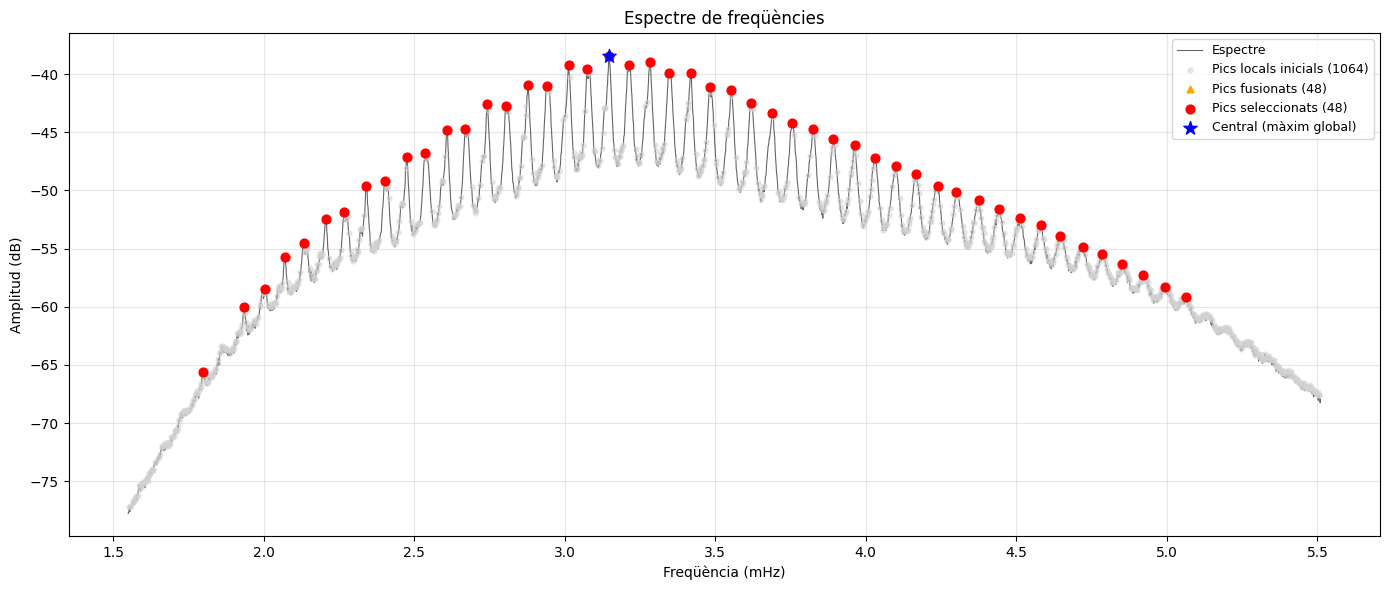

In [5]:
# Visualitzar amb o sense pics fusionats segons el mode
show_merged = SELECTION_MODE == 'central'  # Només mostrar pics fusionats per Sol
plot_spectrum(freqs, amps, initial_peaks, merged_peaks, selected_peaks, global_max_idx, 
              freq_unit=FREQ_UNIT, show_merged=show_merged)

## 4. Anàlisi de diferències

In [6]:
# Calculem diferències
pairwise_diffs = compute_pairwise_differences(freqs, selected_peaks)
deltas = np.array([d[1] for d in pairwise_diffs])

print(f"Diferència mínima: {deltas.min():.6f} mHz")
print(f"Diferència màxima: {deltas.max():.6f} mHz")
print(f"Diferència mitjana: {deltas.mean():.6f} mHz")

Diferència mínima: 0.059509 mHz
Diferència màxima: 3.263855 mHz
Diferència mitjana: 1.112619 mHz


## 5. Histograma

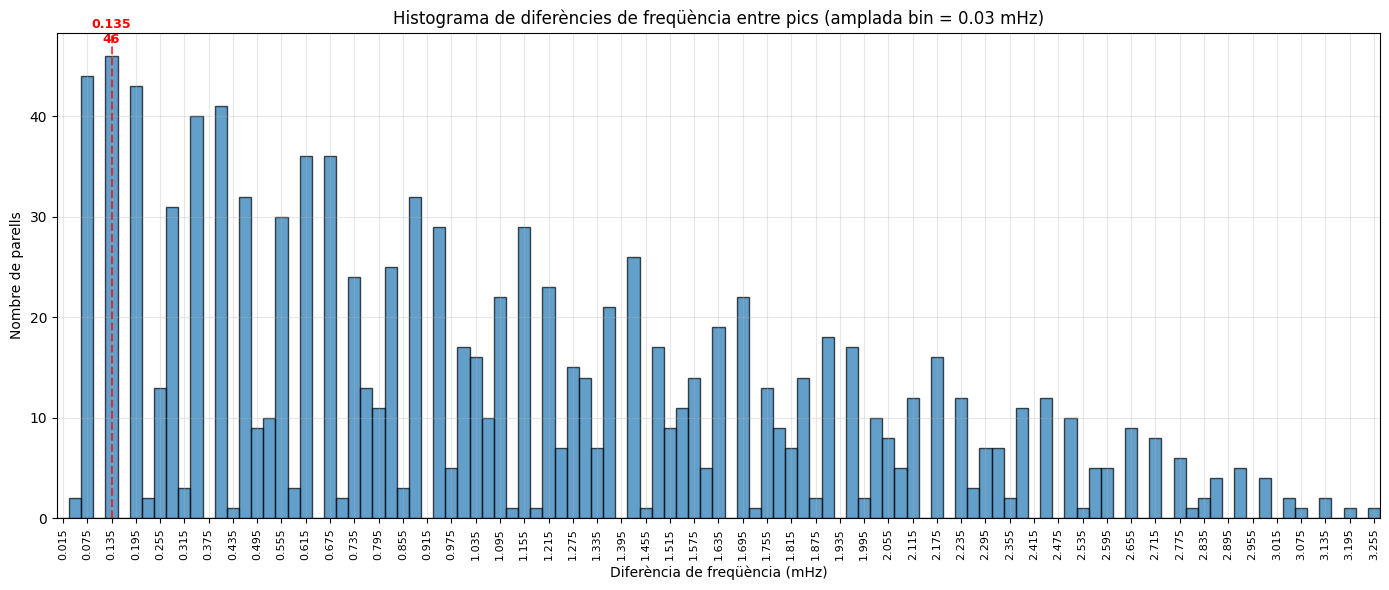


Bins amb més parells (excloent zona < 0.000 mHz):
  0.135 mHz: 46 parells
  0.075 mHz: 44 parells
  0.195 mHz: 43 parells
  0.405 mHz: 41 parells
  0.345 mHz: 40 parells


In [7]:
# Calcular autocorrelació només per estrelles (mode amplitude)
autocorr_peak = None
if SELECTION_MODE == 'amplitude':
    lags, autocorr, autocorr_peak = compute_autocorrelation(
        freqs, amps, 
        freq_range_min=FREQ_RANGE_MIN,
        freq_range_max=FREQ_RANGE_MAX,
        exclude_near_zero=0.05
    )
    print(f"\nPic màxim d'autocorrelació: {autocorr_peak:.3f} {FREQ_UNIT}")

# Per al Sol (mode central), no excloure zona propera a zero
exclude_near_zero_hist = (SELECTION_MODE == 'amplitude')
plot_histogram(deltas, bin_width=BIN_WIDTH, freq_unit=FREQ_UNIT, 
               autocorr_peak=autocorr_peak, exclude_near_zero=exclude_near_zero_hist)

## 5b. Visualització espectre i autocorrelació

In [8]:
# Visualització combinada només per estrelles (mode amplitude)
if SELECTION_MODE == 'amplitude' and autocorr_peak is not None:
    plot_spectrum_with_autocorrelation(
        freqs, amps, selected_peaks,
        lags, autocorr, autocorr_peak,
        freq_unit=FREQ_UNIT,
        title_prefix=DATA_FILE.split('/')[-1].replace('.csv', '').replace('dades/', ''),
        freq_range_min=FREQ_RANGE_MIN,
        freq_range_max=FREQ_RANGE_MAX
    )

## 6. Exportació de resultats

In [9]:
# Recalculem l'histograma per tenir counts i edges
bins = np.arange(0.0, deltas.max() + BIN_WIDTH, BIN_WIDTH)
counts, edges = np.histogram(deltas, bins=bins)

save_results(freqs, amps, selected_peaks, global_max_idx, 
             pairwise_diffs, counts, edges, OUTPUT_DIR, BIN_WIDTH, FREQ_UNIT)

Pics seleccionats guardats a: output/sol\peaks_around_central.csv
Diferències entre parells guardades a: output/sol\pairwise_differences.csv
Histograma guardat a: output/sol\histogram_0.03mHz.csv
